In [1]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress

%matplotlib inline
import seaborn as sns

In [2]:
#Refrence to Csv files 
cab_ride_df = pd.read_csv("Cab-Weather-Data/cab_rides.csv")
weather_df = pd.read_csv("Cab-Weather-Data/weather.csv")
 

In [3]:
# Cleaning Weather Data
# The timestamps were listed in epoch formatting, and needs to be converted to a readable date format

weather_df["date"] = pd.to_datetime(weather_df["time_stamp"], unit="s")

# Reorder the columns for readability
clean_weather_df = weather_df[["date","location","temp","clouds","pressure","rain","humidity","wind"]]


# Reset the index and change the location header to source. This is so our merge will align on common time point & weather conditions at pick up location
new_weather_df = clean_weather_df.reset_index(drop=True)
new_weather_df.rename(columns={"location":"source"}, inplace=True)
new_weather_df.head()

,date,source,temp,clouds,pressure,rain,humidity,wind
0,2018-12-16 23:45:01,Back Bay,42.42,1.0,1012.14,0.1228,0.77,11.25
1,2018-12-16 23:45:01,Beacon Hill,42.43,1.0,1012.15,0.1846,0.76,11.32
2,2018-12-16 23:45:01,Boston University,42.50,1.0,1012.15,0.1089,0.76,11.07
3,2018-12-16 23:45:01,Fenway,42.11,1.0,1012.13,0.0969,0.77,11.09
4,2018-12-16 23:45:01,Financial District,43.13,1.0,1012.14,0.1786,0.75,11.49


In [4]:
# Cleaning Car Ride Data
# The epoch timestamp in this table is represented in milliseconds, so we divide by 1000 to find the time in value of seconds
cab_ride_df["date"]=pd.to_datetime(cab_ride_df["time_stamp"]/1000, unit="s")

# Removing unwanted columns like id and product_id
clean_cab_df = cab_ride_df[["date","source","destination","distance","price","surge_multiplier","cab_type", "name"]]

# Resetting the index
new_cab_df=clean_cab_df.reset_index(drop=True)
new_cab_df.head()


,date,source,destination,distance,price,surge_multiplier,cab_type,name
0,2018-12-16 09:30:07.890000128,Haymarket Square,North Station,0.44,5.0,1.0,Lyft,Shared
1,2018-11-27 02:00:23.676999936,Haymarket Square,North Station,0.44,11.0,1.0,Lyft,Lux
2,2018-11-28 01:00:22.197999872,Haymarket Square,North Station,0.44,7.0,1.0,Lyft,Lyft
3,2018-11-30 04:53:02.749000192,Haymarket Square,North Station,0.44,26.0,1.0,Lyft,Lux Black XL
4,2018-11-29 03:49:20.223000064,Haymarket Square,North Station,0.44,9.0,1.0,Lyft,Lyft XL


In [5]:
#Merge the datesets into a single one based on time_stamp and location
cleaned_merged_df = pd.merge_asof(new_cab_df.sort_values("date"), new_weather_df.sort_values("date"), 
                            left_by=  ['source' ],right_by= ['source' ] ,
                            left_on=  ['date']   ,right_on= ['date'], tolerance=pd.Timedelta(minutes = 15 ) )
cleaned_merged_df.head()



,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,NaN,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,NaN,1.0,Uber,Taxi,40.80,0.87,1014.39,NaN,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,NaN,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,NaN,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,NaN,0.93,1.36


In [6]:
#dataframe info 
cleaned_merged_df.describe


<bound method NDFrame.describe of                                 date                   source  \
0      2018-11-26 03:40:46.318000128        Boston University   
1      2018-11-26 03:40:46.319000064         Theatre District   
2      2018-11-26 03:40:46.319000064            South Station   
3      2018-11-26 03:40:46.320000000         Theatre District   
4      2018-11-26 03:40:46.320000000  Northeastern University   
...                              ...                      ...   
693066 2018-12-18 19:15:10.943000064  Northeastern University   
693067 2018-12-18 19:15:10.943000064              Beacon Hill   
693068 2018-12-18 19:15:10.943000064  Northeastern University   
693069 2018-12-18 19:15:10.943000064  Northeastern University   
693070 2018-12-18 19:15:10.943000064  Northeastern University   

             destination  distance  price  surge_multiplier cab_type  \
0       Theatre District      3.03   34.0               1.0     Lyft   
1              North End      1.57    NaN

In [7]:
# To ensure we have all rows that have weather conditions present, we want to drop all null values in the Temperature column
# Null values for rain or wind is ok because these are logical weather conditions
final_df=cleaned_merged_df.dropna(subset=["temp"])
final_df=final_df.reset_index(drop=True)

# With the null values in other rows, we can fill them with "0"
final_df.fillna(0,inplace=True)
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36


In [8]:
#Count the numbers of temp 
final_df["temp"].count

<bound method Series.count of 0         41.07
1         40.80
2         40.86
3         40.80
4         40.81
          ...  
251822    31.20
251823    30.80
251824    30.80
251825    30.91
251826    31.20
Name: temp, Length: 251827, dtype: float64>

In [9]:
# Adding the day of the week to our table to see if that may have any correlation to weather
final_df["day_of_week"]=final_df["date"].dt.day_name()
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day_of_week
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36,Monday
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60,Monday
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55,Monday
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday


In [10]:
#Adding Month to the table 
final_df["month"] = final_df['date'].dt.month
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day_of_week,month
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36,Monday,11
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60,Monday,11
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday,11


In [11]:
# Formatting some columns to show accurate values
final_df["clouds"]=final_df["clouds"]*100
final_df["humidity"]=final_df["humidity"]*100


In [12]:
# Pretty-fying our final dataframe by including units of measurement for easy analysis

final_df = final_df.rename(columns={"date":"Date","day_of_week":"Weekday","source":"Pick_Up_Location","destination":"Destination",
                                    "distance":"Distance(m)","price":"Price($)","surge_multiplier":"Surge_Multiplier",
                                    "cab_type":"Rideshare_App","name":"Ride_Type","temp":"Temp(C)",
                                    "clouds":"Cloudiness(%)","pressure":"Pressure(MB)","rain":"Rainfall(in)",
                                    "humidity":"Humidity(%)","wind":"Wind_Speed(mph)", "month":"Month"})

final_df = final_df[["Date","Month","Weekday","Pick_Up_Location","Destination","Distance(m)","Price($)","Surge_Multiplier","Rideshare_App","Ride_Type",
                     "Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)"]]
final_df.head()

,Date,Month,Weekday,Pick_Up_Location,Destination,Distance(m),Price($),Surge_Multiplier,Rideshare_App,Ride_Type,Temp(C),Cloudiness(%),Pressure(MB),Rainfall(in),Humidity(%),Wind_Speed(mph)
0,2018-11-26 03:40:46.318000128,11,Monday,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,86.0,1014.39,0.0,92.0,1.36
1,2018-11-26 03:40:46.319000064,11,Monday,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55
2,2018-11-26 03:40:46.319000064,11,Monday,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,87.0,1014.39,0.0,93.0,1.60
3,2018-11-26 03:40:46.320000000,11,Monday,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,87.0,1014.39,0.0,93.0,1.55
4,2018-11-26 03:40:46.320000000,11,Monday,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36


In [13]:
#count of Rides with price 0 
final_df [ final_df["Price($)"]==0]["Price($)"].count()

20098

In [14]:
# Save the dataframe into a csv file to analyze further
final_df.to_csv("rideshare_vs_weather.csv", index=False)

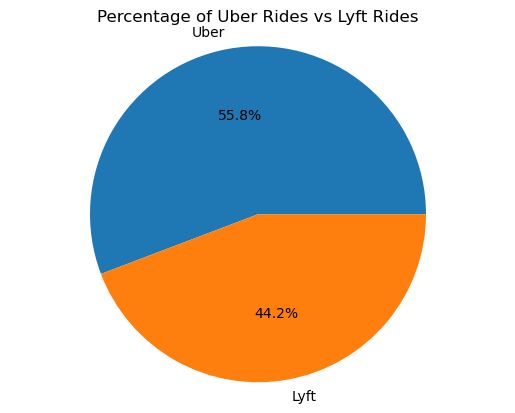

In [15]:
#Pie chart created to see the percentage of lyft rides to Uber Rides
ride_counts = final_df["Rideshare_App"].value_counts()

percentages = (ride_counts / ride_counts.sum()) * 100

plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%')
plt.title('Percentage of Uber Rides vs Lyft Rides') 
plt.axis('equal')
plt.show()

In [16]:
#find the min and max distance of the trips to find the ranges 

maximum_distance = final_df["Distance(m)"].max()
minimum_distance = final_df["Distance(m)"].min()

print("Maximum Distance:", maximum_distance)
print("Minimum Distance:", minimum_distance)

Maximum Distance: 7.5
Minimum Distance: 0.02


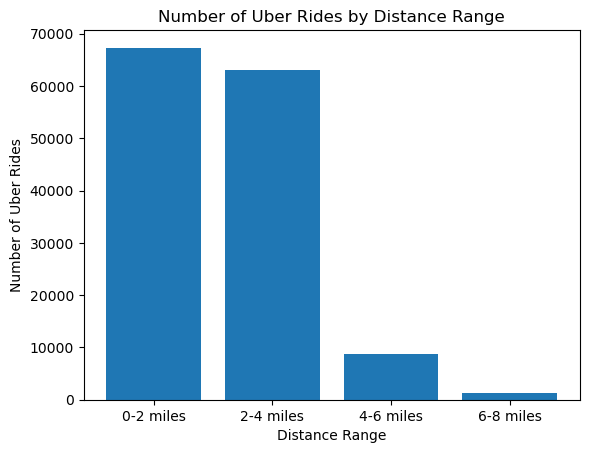

In [17]:
# Filter the DataFrame to include only Uber rides
uber_rides = final_df[final_df["Rideshare_App"] == "Uber"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Uber rides within each distance range
ride_counts = [
    ((uber_rides["Distance(m)"] >= 0) & (uber_rides["Distance(m)"] <= 2)).sum(),
    ((uber_rides["Distance(m)"] > 2) & (uber_rides["Distance(m)"] <= 4)).sum(),
    ((uber_rides["Distance(m)"] > 4) & (uber_rides["Distance(m)"] <= 6)).sum(),
    ((uber_rides["Distance(m)"] > 6) & (uber_rides["Distance(m)"] <= 8)).sum()
]

# Plot the bar graph
plt.bar(distance_ranges, ride_counts)
plt.xlabel("Distance Range")
plt.ylabel("Number of Uber Rides")
plt.title("Number of Uber Rides by Distance Range")
plt.show()

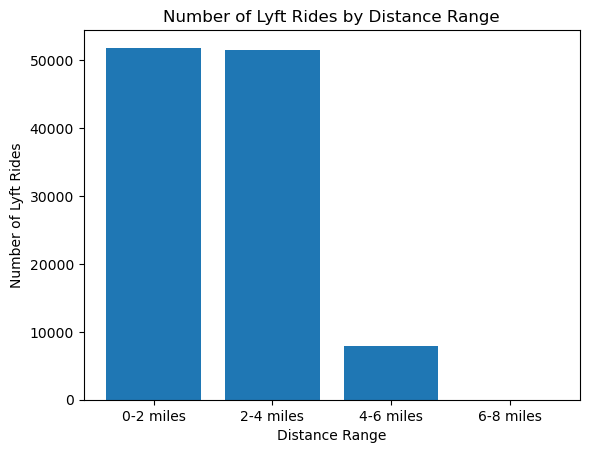

In [18]:
# Filter the DataFrame to include only Lyft rides
lyft_rides = final_df[final_df["Rideshare_App"] == "Lyft"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Lyft rides within each distance range
ride_counts = [
    ((lyft_rides["Distance(m)"] >= 0) & (lyft_rides["Distance(m)"] <= 2)).sum(),
    ((lyft_rides["Distance(m)"] > 2) & (lyft_rides["Distance(m)"] <= 4)).sum(),
    ((lyft_rides["Distance(m)"] > 4) & (lyft_rides["Distance(m)"] <= 6)).sum(),
    ((lyft_rides["Distance(m)"] > 6) & (lyft_rides["Distance(m)"] <= 8)).sum()
]

# Plot the bar graph
plt.bar(distance_ranges, ride_counts)
plt.xlabel("Distance Range")
plt.ylabel("Number of Lyft Rides")
plt.title("Number of Lyft Rides by Distance Range")
plt.show()

In [19]:
# Total revenue for both lyft and uber
revenue_df=final_df.groupby("Rideshare_App")["Price($)"].sum()
revenue_df


Rideshare_App
Lyft    1930455.15
Uber    1902764.00
Name: Price($), dtype: float64

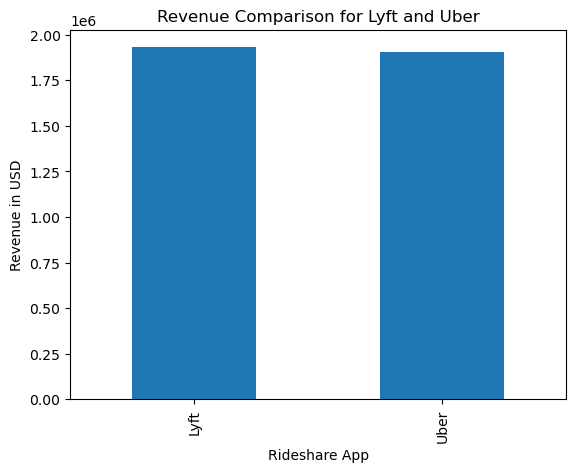

In [20]:
#Bar plot showing the revenue base on both rideshare apps
revenue_df.plot(kind='bar')
plt.title("Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()

In [21]:
#Lyft Monthly Revenue 
lyft=final_df[final_df["Rideshare_App"]=="Lyft"]
lyft_monthly_rev=lyft.groupby("Month")["Price($)"].sum()
lyft_monthly_rev

Month
11    1126795.80
12     803659.35
Name: Price($), dtype: float64

In [22]:
#Uber Monthly Revenue 
uber=final_df[final_df["Rideshare_App"]=="Uber"]
uber_monthly_rev=uber.groupby(["Month"])["Price($)"].sum()
uber_monthly_rev

Month
11    1117151.5
12     785612.5
Name: Price($), dtype: float64

In [23]:
#Created Dataframe to show revenue based on each rideshare app
monthly_rev_df=pd.DataFrame({"Lyft":lyft_monthly_rev,"Uber":uber_monthly_rev})
monthly_rev_df

,Lyft,Uber
Month,,
11,1126795.80,1117151.5
12,803659.35,785612.5


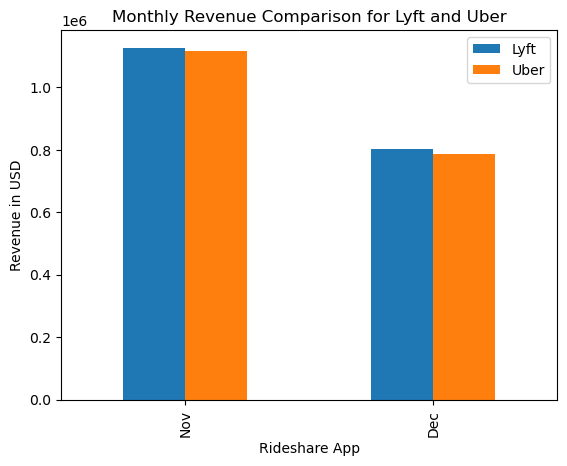

In [24]:
#Bar chart to show revenue based on months
ax=monthly_rev_df.plot.bar()
labels=['Nov','Dec']
ax.set_xticklabels(labels)
plt.title("Monthly Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()

In [25]:
#Generate a summary statistics of mean, median, variance, standard deviation, and SEM of the price for Lyft and Uber 

ride_app = final_df.groupby("Rideshare_App")

count_rides = ride_app["Price($)"].count()
mean_price = ride_app["Price($)"].mean()
median_price = ride_app["Price($)"].median()
var_price = ride_app["Price($)"].var()
std_price = ride_app["Price($)"].std()
sem_price = ride_app["Price($)"].sem()
min_price = ride_app["Price($)"].min()
max_price = ride_app["Price($)"].max()
price_rideApp_df = pd.DataFrame({"Price Mean":mean_price , 
                            "Price Median ":median_price,
                             "Price Variance":var_price,
                             "Price Std. Dev.":std_price,
                             "Price Std. Err.":sem_price,
                                "Total rides" :count_rides,
                                "Max Price" : max_price,
                                "Min Price": min_price})
price_rideApp_df

,Price Mean,Price Median,Price Variance,Price Std. Dev.,Price Std. Err.,Total rides,Max Price,Min Price
Rideshare_App,,,,,,,,
Lyft,17.335110,16.5,100.338586,10.016915,0.030017,111361,92.0,2.5
Uber,13.546082,11.0,93.315272,9.659983,0.025775,140466,89.5,0.0


Lyft has higher price on avaerage (17.34 vs.13.55  )and the Standard deviation is higher (10.02 vs. 9.66). 
Lyft max price is 92.0 and the min price is 2.5.
Uber max price is 89.5 and the min price is 0.0.

In [26]:
# Create a sorted value list to sort day of the week result
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


In [27]:
# higehst price of the Uber rides / indexed based on cats variable
uber_rides = final_df[ final_df["Rideshare_App"]=="Uber"]
uber_highestday_price=uber_rides.groupby(["Weekday"])["Price($)"].mean().reindex(cats)
uber_highestday_price

Weekday
Monday       13.540345
Tuesday      13.556304
Wednesday    13.520725
Thursday     13.599944
Friday       13.414310
Saturday     13.557390
Sunday       13.604709
Name: Price($), dtype: float64

In [28]:
# higehst price of the Lyft rides / indexed based on cats variable
lyft_rides = final_df[ final_df["Rideshare_App"]=="Lyft"]
lyft_highestday_price=lyft_rides.groupby(["Weekday"])["Price($)"].mean().reindex(cats)
lyft_highestday_price


Weekday
Monday       17.301735
Tuesday      17.312292
Wednesday    17.251150
Thursday     17.424526
Friday       17.288538
Saturday     17.219977
Sunday       17.609578
Name: Price($), dtype: float64

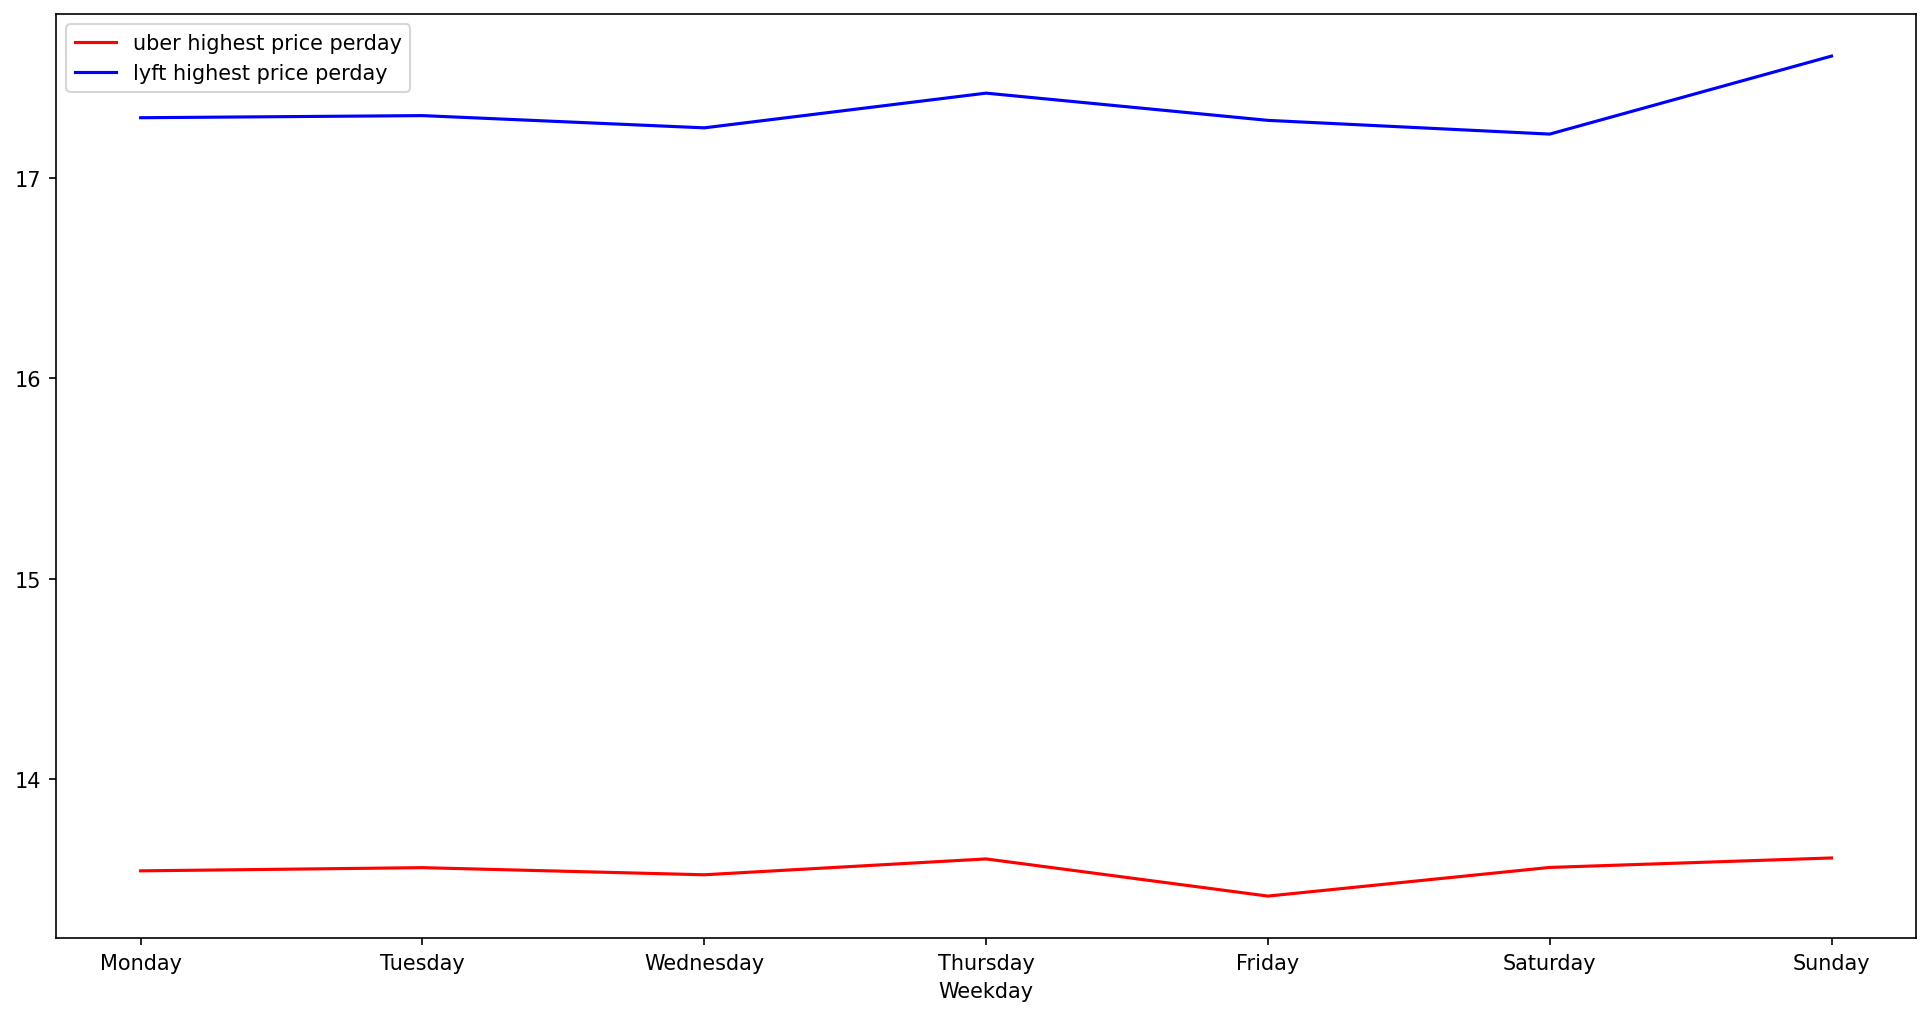

In [29]:
#created the line chart to show price difference based on most expensive day of the week for each ride app 
plt.figure(figsize=(16, 8), dpi=150)
uber_highestday_price.plot(color ="r", label ="uber highest price perday")
lyft_highestday_price.plot(color ="b", label ="lyft highest price perday")
plt.legend()


Avaerage of the price for each app on different days of the week is relatively constant and does not change a lot. 

In [30]:
# create rides into list for loop
ride_list = ["Lyft", "Uber"]

#Create empty list to fill with price data (for plotting)
price_list =[]

for ride in ride_list:
    
    price = final_df[ final_df["Rideshare_App"]==ride]["Price($)"] 
    
    price_list.append(price)
    
    # Determine outliers using upper and lower bounds
    quartiles = price.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    # print if the counter is empty and add a space between each regimen
    
   
    print(f"The IQR data for {ride} is:")
    print(f"The lower quartile of {ride} is: {lowerq}")
    print(f"The upper quartile of {ride} is: {upperq}")
    print(f"The interquartile range of {ride} is: {iqr}")
    print(f"The the median of {ride} is: {quartiles[0.5]}")
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.")
    print(f"")
   


The IQR data for Lyft is:
The lower quartile of Lyft is: 9.0
The upper quartile of Lyft is: 22.5
The interquartile range of Lyft is: 13.5
The the median of Lyft is: 16.5
Values below -11.25 could be outliers.
Values above 42.75 could be outliers.

The IQR data for Uber is:
The lower quartile of Uber is: 7.5
The upper quartile of Uber is: 19.0
The interquartile range of Uber is: 11.5
The the median of Uber is: 11.0
Values below -9.75 could be outliers.
Values above 36.25 could be outliers.



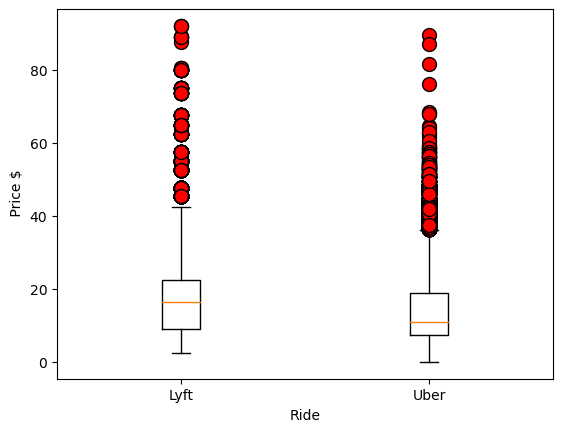

In [31]:
# Generate a box plot that shows the distrubution of the price based on each ride app.
flierprops = dict(marker='o', markerfacecolor='r', markersize=10, markeredgecolor='black')

fig1, ax1 = plt.subplots()
ax1.set_ylabel(" Price $")
ax1.set_xlabel("Ride")
ax1.boxplot(price_list, flierprops=flierprops)
ax1.set_xticklabels(ride_list)

plt.show()

<Axes: >

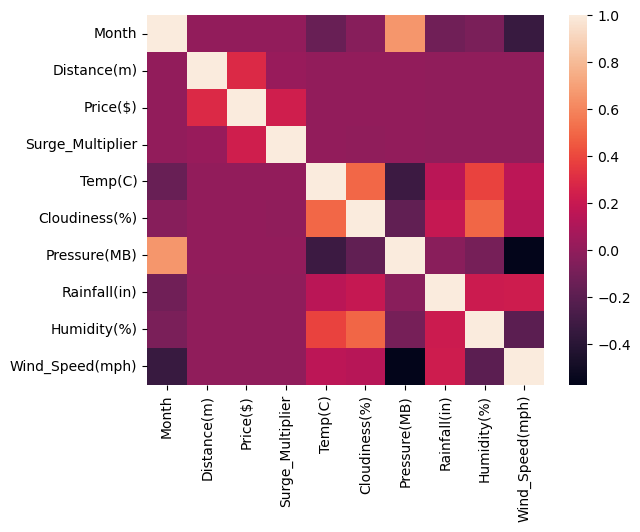

In [32]:
# Plot the correlation heat map among numeric columns

# load the Auto dataset
auto_df = sns.load_dataset('mpg')

# calculate the correlation matrix on the numeric columns
corr = final_df.select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)

In [33]:
#Bining the distance
bins = [0,1,2,3,4,5,6,7,8]
final_df["dist"] =  pd.cut(final_df["Distance(m)"].astype(float),bins)
final_df[["Distance(m)","dist"]].head(20)


,Distance(m),dist
0,3.03,"(3, 4]"
1,1.57,"(1, 2]"
2,1.30,"(1, 2]"
3,2.71,"(2, 3]"
4,2.43,"(2, 3]"
5,2.71,"(2, 3]"
6,2.71,"(2, 3]"
7,2.19,"(2, 3]"
8,3.05,"(3, 4]"
9,2.19,"(2, 3]"


In [40]:
#Study the relationship between price and the distance
# Calculate the correlation coefficient and a linear regression model 
#  for price and distance for the entire rides based on different app


uber_rides=final_df.loc[final_df["Rideshare_App"] =="Uber"]
uber_rides = uber_rides.groupby("dist").mean()

# Count the number of Lyft rides within each distance range

uber_price = uber_rides["Price($)"]
uber_distance = uber_rides["Distance(m)"]

corr = round(st.pearsonr(uber_distance, uber_price )[0],2)
print(f"The correlation between price of Uber rides and the Distance  {corr}")


#linear regression model
linear_reg = st.linregress( uber_rides["Distance(m)"],uber_rides["Price($)"])
linear_reg



The correlation between price of Uber rides and the Distance  0.98


LinregressResult(slope=1.9292224884913294, intercept=9.513920632280826, rvalue=0.983642498199723, pvalue=1.080805768824821e-05, stderr=0.14423132621708012, intercept_stderr=0.6599576196872612)

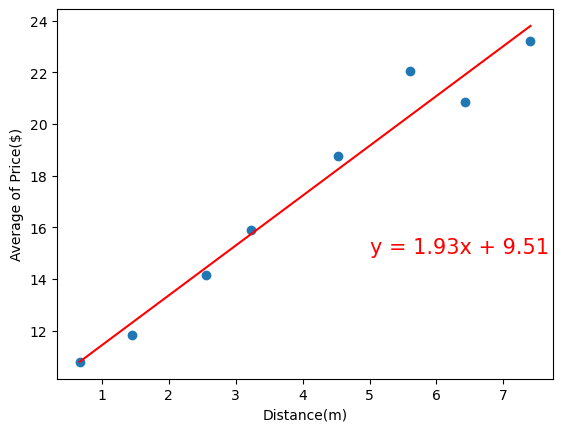

In [44]:
# plot the regression line on the scatter plot
uber_rides=final_df.loc[final_df["Rideshare_App"] =="Uber"]


plt.scatter(uber_distance, uber_price)

#linear regression equation and plot the line
uber_price_predict = uber_distance * linear_reg.slope + linear_reg.intercept
plt.plot(uber_distance, uber_price_predict, color='red')
line_eq = "y = " + str(round(linear_reg.slope,2)) + "x + " + str(round(linear_reg.intercept,2))
plt.annotate(line_eq,(5,15),fontsize=15,color="red")
plt.xlabel("Distance(m)")
plt.ylabel("Average of Price($)")
plt.show()

In [47]:
#Study the relationship between price and the distance
# Calculate the correlation coefficient and a linear regression model 
# for price and distance for the entire rides based on different app


lyft_rides=final_df.loc[final_df["Rideshare_App"] =="Lyft"]
lyft_rides = lyft_rides.groupby("dist").mean()
lyft_rides = lyft_rides.dropna()

# Count the number of Lyft rides within each distance range

lyft_price = lyft_rides["Price($)"]
lyft_distance = lyft_rides["Distance(m)"]

corr = round(st.pearsonr(lyft_distance, lyft_price )[0],2)
print(f"The correlation between price of Lyft rides and the Distance  {corr}")


#linear regression model
linear_reg = st.linregress( lyft_rides["Distance(m)"],lyft_rides["Price($)"])
linear_reg



The correlation between price of Lyft rides and the Distance  1.0


LinregressResult(slope=3.380618808291159, intercept=10.054375053891826, rvalue=0.9971903122114381, pvalue=8.024999068803234e-07, stderr=0.11357216583216154, intercept_stderr=0.4390637844809005)

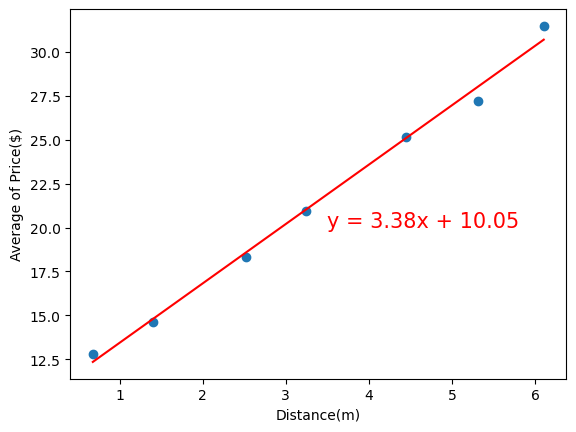

In [46]:
# plot the regression line on the scatter plot
lyft_rides=final_df.loc[final_df["Rideshare_App"] =="Lyft"]


plt.scatter(lyft_distance, lyft_price)
#linear regression equation and plot the line
lyft_price_predict = lyft_distance * linear_reg.slope + linear_reg.intercept
plt.plot(lyft_distance, lyft_price_predict, color='red')
line_eq = "y = " + str(round(linear_reg.slope,2)) + "x + " + str(round(linear_reg.intercept,2))
plt.annotate(line_eq,(3.5,20),fontsize=15,color="red")
plt.xlabel("Distance(m)")
plt.ylabel("Average of Price($)")
plt.show()


Lyft charges more for based rides compare to Uber (10.05 vs. 9.50) and charges more for each additional miles compare to Uber (3.38 vs. 1.93) 